# Modeling

## 1 Contents
- [1 Contents](#1-Contents)
- [2 Introduction](#2-Introduction)
- [3 Imports](#3-Imports)
- [4 Load Data](#4-Load-Data)
- [5 Models](#5-Models)
  - [5.1 Preliminary Models](#5.1-Preliminary-Models)
    - 5.1.1 Linear regression
    - 5.1.2 Ridge regression
    - 5.1.3 Random forest regression
    - 5.1.4 Gradient boosting regression
    - 5.1.5 AdaBoost regression
    - 5.1.6 Model scores
  - [5.2 Hyperparameter Tuning](#5.2-Hyperparameter-Tuning)
    - 5.2.1 Random forest regression hyperparameter tuning
    - 5.2.2 Gradient boosting regression hyperparameter tuning
  - [5.3 Model Selection](#5.3-Model-Selection)
- [6 Conclusion](#6-Conclusion)

## 2 Introduction

The purpose of this notebook is to develop a model that can predict the number of fires in a county using information about the county.

A handful of regressors will be used out-of-the-box from [scikit-learn](https://scikit-learn.org/stable/index.html): `LinearRegression`, `Ridge`, `RandomForestRegressor`, `GradientBoostingRegressor`, and `AdaBoostRegressor` to get an idea of a starting point before jumping into hyperparameter tuning. As they are regressors, the metrics that will be looked at are the R-squared, root mean squared error (RMSE), and mean absolute error (MAE).

## 3 Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
import time
import joblib

## 4 Load Data

In [2]:
train_df = pd.read_pickle('../data/processed/3-0_train_df.pkl')
test_df = pd.read_pickle('../data/processed/3-0_test_df.pkl')

In [3]:
train_df.shape, test_df.shape

((290, 60), (116, 60))

In [4]:
train_df.head(3)

,StartedYear,NumFires,Area_sqmi,DM_Alpine,DM_Amador,DM_Butte,DM_Calaveras,DM_Colusa,DM_Contra Costa,DM_Del Norte,...,DM_Sonoma,DM_Stanislaus,DM_Sutter,DM_Tehama,DM_Trinity,DM_Tulare,DM_Tuolumne,DM_Ventura,DM_Yolo,DM_Yuba
0,2013,4,738,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2014,0,738,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015,5,738,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_df.head(3)

,StartedYear,NumFires,Area_sqmi,DM_Alpine,DM_Amador,DM_Butte,DM_Calaveras,DM_Colusa,DM_Contra Costa,DM_Del Norte,...,DM_Sonoma,DM_Stanislaus,DM_Sutter,DM_Tehama,DM_Trinity,DM_Tulare,DM_Tuolumne,DM_Ventura,DM_Yolo,DM_Yuba
5,2018,8,738,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2019,9,738,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,2018,0,739,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_df['NumFires'].describe()

count    290.000000
mean       3.582759
std        5.021240
min        0.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       52.000000
Name: NumFires, dtype: float64

In [7]:
train_df['StartedYear'].describe()

count     290.000000
mean     2015.000000
std         1.416658
min      2013.000000
25%      2014.000000
50%      2015.000000
75%      2016.000000
max      2017.000000
Name: StartedYear, dtype: float64

In [8]:
test_df['StartedYear'].describe()

count     116.000000
mean     2018.500000
std         0.502169
min      2018.000000
25%      2018.000000
50%      2018.500000
75%      2019.000000
max      2019.000000
Name: StartedYear, dtype: float64

## 5 Models

Before beginning, the training and testing dataframes are split into the independent and dependent variables.

In [9]:
X_var_names = ['Area_sqmi']
y_var_name = 'NumFires'

In [10]:
X_train = train_df.drop([y_var_name,'StartedYear'], axis=1).values
y_train = train_df[y_var_name].values
X_test = test_df.drop([y_var_name,'StartedYear'], axis=1).values
y_test = test_df[y_var_name].values

model_scores = []

### 5.1 Preliminary Models

Two functions are defined for reuse on some preliminary models: `get_scores()` will get the R-squared, RMSE, and MAE for a model, and `print_scores()` simply assists in printing these values.

In [11]:
def get_scores(model, X_train, y_train, X_test, y_test, name, want_print=True):
    """
    This function finds the R^2, RMSE, and MAE. It can print the scores.
    
    model - The model that will fit, predict, and score.
    X_train, y_train - The training set
    X_test, y_test - The testing set
    name - The name of the model
    want_print - If true, will print the three scores
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r_squared = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    scores = [name, r_squared, rmse, mae]
    if (want_print):
        print_scores(scores)
    return scores

In [12]:
def print_scores(scores):
    """
    This function prints the name of a model and its R^2, MSE, and MAE.
    scores - a list containing the name, R^2, MSE, and MAE, in this order
    """
    if (len(scores) >= 4):
        print("{}:".format(scores[0]))
        print("\tR^2 = {}".format(scores[1]))
        print("\tMSE = {}".format(scores[2]))
        print("\tMAE = {}".format(scores[3]))
    else:
        print("Check scores array.")

#### 5.1.1 Linear regression

A linear regression model is tried first. Something to keep in mind with this is that some of our X features are correlated with one another.

In [13]:
lr_model = LinearRegression()
lr_scores = get_scores(lr_model, X_train, y_train, X_test, y_test, "Linear")
model_scores.append(lr_scores)

Linear:
	R^2 = 0.5737930561116402
	MSE = 3.3279381625555176
	MAE = 2.2241379310358362


In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(LinearRegression(), X_train, y_train, cv=kf, scoring='r2')
print(cv_scores)
print(np.mean(cv_scores), np.std(cv_scores))

[ 0.20943661  0.06133545  0.30961762 -0.30801849  0.11434415]
0.07734306979844996 0.21048944430116215


#### 5.1.2 Ridge regression

Ridge regression will also be tried. However, as seen below, the closer alpha gets to 0, the better it seems to perform, so it just approaches linear regression.

In [15]:
for alpha in [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]:
    ridge_model = Ridge(alpha=alpha)
    name = "Ridge alpha=" + str(alpha)
    ridge_scores = get_scores(ridge_model, X_train, y_train, X_test, y_test, name)
    model_scores.append(ridge_scores)

Ridge alpha=0.01:
	R^2 = 0.5731641110344374
	MSE = 3.3303927432948743
	MAE = 2.2255270827578078
Ridge alpha=0.1:
	R^2 = 0.5683078105064282
	MSE = 3.3492848343311374
	MAE = 2.235868424760108
Ridge alpha=1.0:
	R^2 = 0.5277641743518511
	MSE = 3.5030348104443076
	MAE = 2.3108689380531757
Ridge alpha=10.0:
	R^2 = 0.2916925412358685
	MSE = 4.290183763718797
	MAE = 2.8493957883170355
Ridge alpha=100.0:
	R^2 = 0.08587922682819393
	MSE = 4.873789595972174
	MAE = 3.2320981675773
Ridge alpha=1000.0:
	R^2 = 0.05073065319439096
	MSE = 4.966606081260391
	MAE = 3.290591672820366


In [16]:
ridge = Ridge(alpha=0.1)
cv_scores = cross_val_score(ridge, X_train, y_train, cv=kf, scoring='r2')
print(cv_scores)
print(np.mean(cv_scores), np.std(cv_scores))

[ 0.21033502  0.08893358  0.3170025  -0.27629946  0.12258279]
0.09251088652974426 0.20060767873472457


#### 5.1.3 Random forest regression

Regressions based on decision trees seem promising, knowing that the dataset has a bit of correlation and due to the numerous categorical features, so Random Forest, Gradient Boost, and AdaBoost will be tested as well. For the preliminary models, the hyperparameters will be arbitrarily chosen.

In [17]:
rfr_model = RandomForestRegressor(max_depth=2, random_state=42)
rfr_scores = get_scores(rfr_model, X_train, y_train, X_test, y_test, "Random Forest")
model_scores.append(rfr_scores)

Random Forest:
	R^2 = 0.3789109539806549
	MSE = 4.017370834001976
	MAE = 2.830672100995492


In [18]:
rfr_model = RandomForestRegressor(max_depth=2, random_state=42)
cv_scores = cross_val_score(rfr_model, X_train, y_train, cv=kf, scoring='r2')
print(cv_scores)
print(np.mean(cv_scores), np.std(cv_scores))

[ 0.12336459  0.04455502  0.27197418 -0.48252105  0.10456381]
0.012387310743723744 0.25852150804222807


#### 5.1.4 Gradient boosting regression

In [19]:
gbr_model = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42, loss='squared_error')
gbr_scores = get_scores(gbr_model, X_train, y_train, X_test, y_test, "Gradient Boosting")
model_scores.append(gbr_scores)

Gradient Boosting:
	R^2 = 0.45493686093664953
	MSE = 3.7634694405365106
	MAE = 2.5889782142452558


In [20]:
gbr_model = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42,
    loss='squared_error')
cv_scores = cross_val_score(gbr_model, X_train, y_train, cv=kf, scoring='r2')
print(cv_scores)
print(np.mean(cv_scores), np.std(cv_scores))

[ 0.16312377  0.1506271   0.33937988 -0.18682361  0.12375011]
0.11801144807631694 0.17032922908488768


#### 5.1.5 AdaBoost regression

In [21]:
adab_model = AdaBoostRegressor(n_estimators=50, random_state=42, learning_rate=0.2)
adab_scores = get_scores(adab_model, X_train, y_train, X_test, y_test, "Ada Boost")
model_scores.append(adab_scores)

Ada Boost:
	R^2 = 0.5196199252084779
	MSE = 3.533112612391143
	MAE = 2.608357783747684


In [22]:
adab_model = AdaBoostRegressor(n_estimators=50, random_state=42, learning_rate=0.2)
cv_scores = cross_val_score(adab_model, X_train, y_train, cv=kf, scoring='r2')
print(cv_scores)
print(np.mean(cv_scores), np.std(cv_scores))

[ 0.13129005 -0.49845456  0.24322994 -1.1235173   0.09045313]
-0.23139974697150523 0.5152860382903797


#### 5.1.6 Model scores

In [23]:
model_scores_df = pd.DataFrame(model_scores, columns=['Name','R^2','RMSE','MAE'])
model_scores_df

,Name,R^2,RMSE,MAE
0,Linear,0.573793,3.327938,2.224138
1,Ridge alpha=0.01,0.573164,3.330393,2.225527
2,Ridge alpha=0.1,0.568308,3.349285,2.235868
3,Ridge alpha=1.0,0.527764,3.503035,2.310869
4,Ridge alpha=10.0,0.291693,4.290184,2.849396
5,Ridge alpha=100.0,0.085879,4.873790,3.232098
6,Ridge alpha=1000.0,0.050731,4.966606,3.290592
7,Random Forest,0.378911,4.017371,2.830672
8,Gradient Boosting,0.454937,3.763469,2.588978
9,Ada Boost,0.519620,3.533113,2.608358


The tree-based regressors performed generally worse than the linear regressor, but their RMSE and MAE were not worse by very much. These performances surely can be improved, since their hyperparameters were not so thoughtfully selected.

Overall, the CV scores were not too great, especially for the AdaBoost regressor. The Linear and Random Forest regressors also produce somewhat stronger negative R-squared, and they have somewhat high standard deviations. Moving forward, the hyperparameters of the Random Forest and Gradient Boosting regressors will be tuned.

### 5.2 Hyperparameter Tuning

#### 5.2.1 Random forest regression hyperparameter tuning

For the `RandomForestRegressor`, we can tune for `n_estimators` and `max_features`.

In [24]:
n_ests = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
params = {
    'n_estimators': n_ests,
    'max_features': [0.2,0.4,0.6,0.8,1.0]
}
rfr_grid_cv = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
             param_grid=params, cv=5, n_jobs=-1)

In [25]:
rfr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': [0.2, 0.4, 0.6, 0.8, 1.0],
                         'n_estimators': [10, 12, 16, 20, 26, 33, 42, 54, 69,
                                          88, 112, 143, 183, 233, 297, 379, 483,
                                          615, 784, 1000]})

In [26]:
rfr_grid_cv.best_params_

{'max_features': 0.2, 'n_estimators': 297}

The parameters selected were to use 20% of the features and to use 297 trees for the forest.

In [27]:
rfr_best = rfr_grid_cv.best_estimator_

In [28]:
rfr_best_cv_scores = cross_val_score(rfr_best, X_train, y_train, cv=kf, scoring='r2')
rfr_best_cv_scores

array([ 0.20037049,  0.09601506,  0.33148782, -0.37325778,  0.12279508])

In [29]:
np.mean(rfr_best_cv_scores), np.std(rfr_best_cv_scores)

(0.07548213283680401, 0.2388152582635638)

Compared to the arbitrarily-set RF model from above in the preliminary models section, it looks as if there is considerable improvement in metrics.

In [30]:
pd.Series(rfr_best.feature_importances_, (train_df.drop([y_var_name,'StartedYear'], axis=1)).columns).sort_values(ascending=False)

Area_sqmi             0.314750
DM_Riverside          0.189291
DM_San Diego          0.061220
DM_Fresno             0.044596
DM_Butte              0.040839
DM_San Luis Obispo    0.032360
DM_Kern               0.032109
DM_Inyo               0.023590
DM_Lake               0.022950
DM_San Bernardino     0.021897
DM_Imperial           0.021249
DM_Shasta             0.021068
DM_Siskiyou           0.018202
DM_Monterey           0.011178
DM_Los Angeles        0.010486
DM_Mariposa           0.010380
DM_Tehama             0.009419
DM_Tulare             0.007260
DM_Santa Clara        0.006235
DM_Mono               0.006063
DM_Lassen             0.006034
DM_Madera             0.005823
DM_Colusa             0.005058
DM_Plumas             0.004993
DM_El Dorado          0.004632
DM_Calaveras          0.004361
DM_Merced             0.003677
DM_Modoc              0.003526
DM_Napa               0.003465
DM_San Francisco      0.003409
DM_Kings              0.003330
DM_Sierra             0.003271
DM_Nevad

The RF model considers the area in square miles to be somewhat important, and then it considers some counties more important than others, but every county is accounted for.

#### 5.2.2 Gradient boosting regression hyperparameter tuning

For the `GradientBoostingRegressor`, we can tune for `n_estimators`, `learning_rate`, and `max_depth`.

In [31]:
gbr_params = {
    'n_estimators': n_ests,
    'learning_rate': [0.1,0.2,0.4,0.6,0.8,1.0],
    'max_depth': [None,1,2,3]
}
gbr_grid_cv = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                          param_grid=gbr_params, cv=5, n_jobs=-1)

In [32]:
gbr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.4, 0.6, 0.8, 1.0],
                         'max_depth': [None, 1, 2, 3],
                         'n_estimators': [10, 12, 16, 20, 26, 33, 42, 54, 69,
                                          88, 112, 143, 183, 233, 297, 379, 483,
                                          615, 784, 1000]})

In [33]:
gbr_grid_cv.best_params_

{'learning_rate': 0.4, 'max_depth': 2, 'n_estimators': 12}

The GridSearchCV selected a learning rate of 0.4, a max depth of 2, and a number of estimators of 12. This model has fewer and shorter trees than the RF model.

In [34]:
gbr_best = gbr_grid_cv.best_estimator_

In [35]:
gbr_best = gbr_grid_cv.best_estimator_

In [36]:
gbr_best_cv_scores = cross_val_score(gbr_best, X_train, y_train, cv=kf, scoring='r2')
gbr_best_cv_scores

array([ 0.19079903,  0.13014078,  0.34894352, -0.17427424,  0.13303208])

In [37]:
np.mean(gbr_best_cv_scores), np.std(gbr_best_cv_scores)

(0.12572823443908326, 0.16978431663469204)

With tuning, this model changed only a little from the arbitrarily-chosen GBR model.

In [38]:
pd.Series(gbr_best.feature_importances_, (train_df.drop([y_var_name,'StartedYear'], axis=1)).columns).sort_values(ascending=False)[:16]

Area_sqmi             0.517204
DM_Riverside          0.213971
DM_Inyo               0.069353
DM_Butte              0.056526
DM_Lake               0.035109
DM_Imperial           0.034299
DM_San Diego          0.029936
DM_Shasta             0.008586
DM_San Luis Obispo    0.008521
DM_Mariposa           0.005733
DM_Lassen             0.005286
DM_Tehama             0.005284
DM_Mono               0.005171
DM_Santa Clara        0.005021
DM_Santa Barbara      0.000000
DM_San Benito         0.000000
dtype: float64

The GB model similarly puts a lot of weight on the area, but it puts a lot more weight on it. As for the counties, it doesn't bother considering most of them.

### 5.3 Model Selection

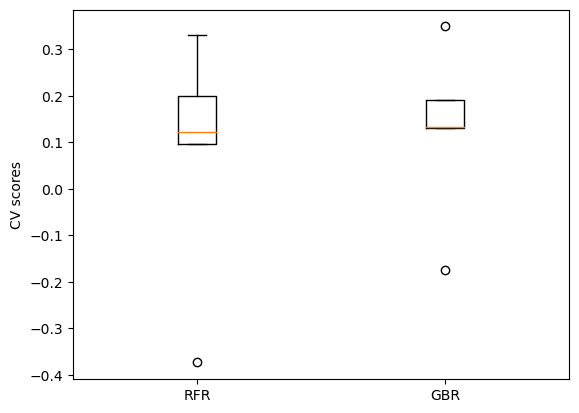

In [39]:
results = {'RFR': rfr_best_cv_scores, 'GBR': gbr_best_cv_scores}
plt.boxplot(results.values(),  labels=results.keys())
plt.ylabel("CV scores")
plt.show()

The range of CV is wider with the Random Forest model, but the two models' medians are comparable. The Gradient Boosting model performs slightly better with cross-validation training sets.

In [40]:
# Random Forest Regressor
start_time = time.time()
rfr_ttest = RandomForestRegressor(max_features=0.2, n_estimators=297, random_state=42).fit(X_train, y_train)
end_time = time.time()
fit_elapsed_time = end_time - start_time

start_time = time.time()
y_pred_rfr = rfr_ttest.predict(X_test)
end_time = time.time()
predict_elapsed_time = end_time - start_time
print(fit_elapsed_time * 1000, predict_elapsed_time * 1000) # ms

406.21352195739746 22.939205169677734


In [41]:
# Gradient Boosting Regressor
start_time = time.time()
gbr_ttest = GradientBoostingRegressor(learning_rate=0.4, max_depth=2, n_estimators=12, random_state=42).fit(X_train, y_train)
end_time = time.time()
fit_elapsed_time = end_time - start_time

start_time = time.time()
y_pred_gbr = gbr_ttest.predict(X_test)
end_time = time.time()
predict_elapsed_time = end_time - start_time
print(fit_elapsed_time * 1000, predict_elapsed_time * 1000)

10.960817337036133 0.0


The Gradient Boosting regressor is a lot faster, which is unsurprising, considering how much smaller the ensemble is and how much shorter the trees are. The Random Forest has 297 trees with expansive leaves.

In [42]:
_ = get_scores(rfr_best, X_train, y_train, X_test, y_test, "Best RFR Model")
_ = get_scores(gbr_best, X_train, y_train, X_test, y_test, "Best GBR Model")

Best RFR Model:
	R^2 = 0.5747791791156027
	MSE = 3.324085976558219
	MAE = 2.221380501059646
Best GBR Model:
	R^2 = 0.489964603938027
	MSE = 3.640534456047771
	MAE = 2.5060850597419


When scoring the two models with the test set, the Random Forest model performs a bit better across the board. Perhaps the Random Forest model having more inclusive county considerations helps it predict the new data. (It also slightly outperforms the Linear Regression model, including in the cross validation training sets except for the one negative value.)

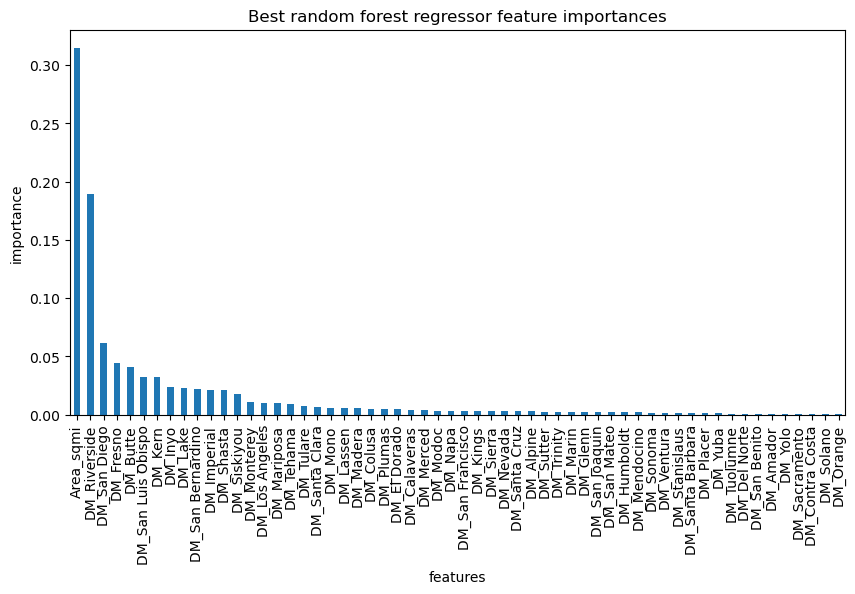

In [43]:
plt.subplots(figsize=(10, 5))
rfr_feat_imps = pd.Series(rfr_best.feature_importances_, index=train_df.drop([y_var_name,'StartedYear'], axis=1).columns).sort_values(ascending=False)
rfr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [44]:
y_pred_rfr

array([2.94036992e+00, 2.94036992e+00, 4.36101515e-01, 4.36101515e-01,
       2.03251381e+00, 2.03251381e+00, 8.86689405e+00, 8.86689405e+00,
       3.39939365e+00, 3.39939365e+00, 1.75364759e-01, 1.75364759e-01,
       1.82298758e+00, 1.82298758e+00, 1.16969746e+00, 1.16969746e+00,
       4.88060796e+00, 4.88060796e+00, 9.71620384e+00, 9.71620384e+00,
       5.87781738e-01, 5.87781738e-01, 3.98249438e+00, 3.98249438e+00,
       1.23773145e+00, 1.23773145e+00, 8.85761463e+00, 8.85761463e+00,
       5.48148513e-01, 5.48148513e-01, 6.42298053e+00, 6.42298053e+00,
       3.14879319e+00, 3.14879319e+00, 6.41695320e+00, 6.41695320e+00,
       5.17598486e+00, 5.17598486e+00, 4.03057100e-01, 4.03057100e-01,
       5.00169856e+00, 5.00169856e+00, 3.42876650e+00, 3.42876650e+00,
       1.79952766e+00, 1.79952766e+00, 4.75544004e+00, 4.75544004e+00,
       1.46288668e+00, 1.46288668e+00, 5.88461766e+00, 5.88461766e+00,
       3.16035062e+00, 3.16035062e+00, 2.98076924e+00, 2.98076924e+00,
      

In [45]:
y_rfr = pd.concat([pd.Series(y_test), pd.Series(y_pred_rfr)], axis=1)
y_rfr[3] = y_rfr[1] - y_rfr[0]
y_rfr

,0,1,3
0,8,2.940370,-5.059630
1,9,2.940370,-6.059630
2,0,0.436102,0.436102
3,0,0.436102,0.436102
4,2,2.032514,0.032514
...,...,...,...
111,4,1.979745,-2.020255
112,0,0.003704,0.003704
113,0,0.003704,0.003704
114,0,0.046801,0.046801


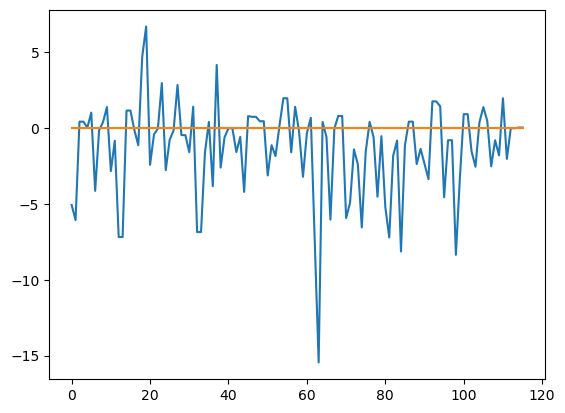

In [46]:
plt.figure()
plt.plot(y_rfr[3])
plt.plot(np.zeros(116))
plt.show()

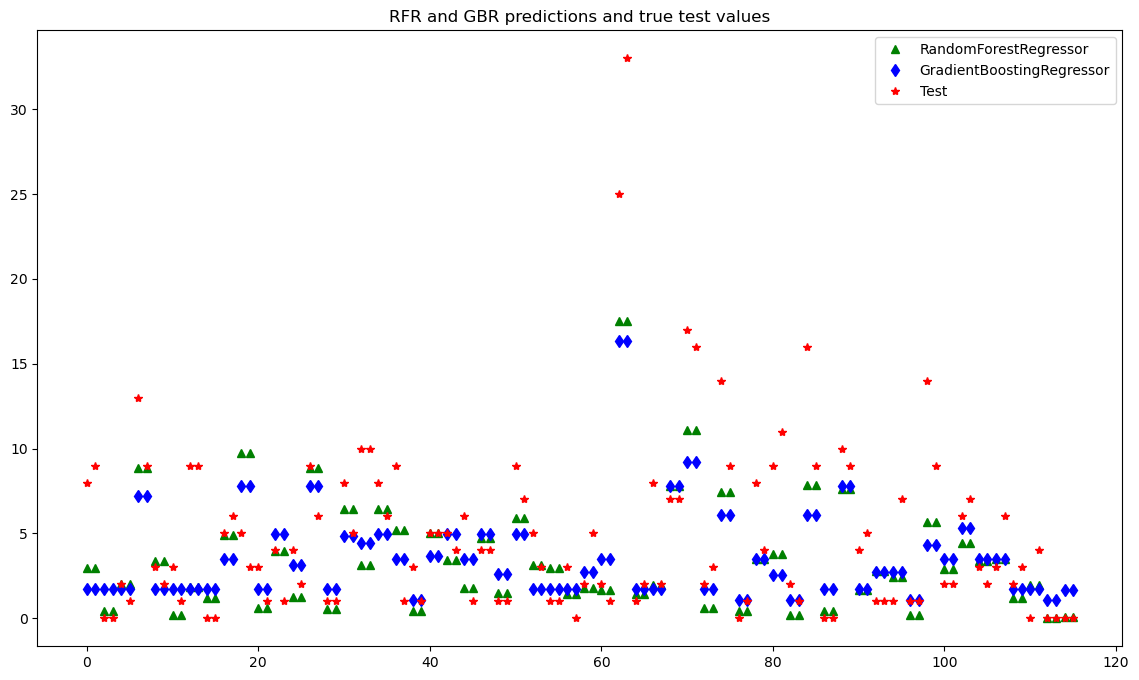

In [47]:
plt.figure(figsize=[14,8])
plt.plot(y_pred_rfr, "g^", label="RandomForestRegressor")
plt.plot(y_pred_gbr, "bd", label="GradientBoostingRegressor")
plt.plot(y_test, "r*", label="Test")
plt.title("RFR and GBR predictions and true test values")
plt.legend(loc="best")

plt.show()

In [48]:
pd.Series(y_pred_rfr).to_csv('../models/y_pred_rfr.csv')

## 6 Conclusion

To start, five models were quickly checked: `LinearRegression`, `Ridge`, `RandomForestRegressor`, `GradientBoostingRegressor`, and `AdaBoostRegressor`. Some of the metrics are displayed in the table below; a few of the Ridge scores were omitted for brevity.

| Name | R^2 | RMSE | MAE |
| --- | --- | --- | --- |
| Linear | 0.573793 | 3.327938 | 2.224138 |
| Ridge α=0.01 | 0.573164 | 3.330393 | 2.225527 |
| Ridge α=0.1 | 0.568308 | 3.349285 | 2.235868 |
| Ridge α=1.0 | 0.527764 | 3.503035 | 2.310869 |
| Ridge α=10.0 | 0.291693 | 4.290184 | 2.849396 |
| Random Forest | 0.378911 | 4.017371 | 2.830672 |
| Gradient Boosting | 0.454937 | 3.763469 | 2.588978 |
| Ada Boost | 0.519620 | 3.533113 | 2.608358 |

The linear regression model performed decently, and the ridge regression model indicated that the closer that alpha was to 0 (the more like standard OLS), the better, so the ridge regressor was ignored from this point. Three decision tree-based algorithms were tested with arbitrary hyperparameters. Given that they were not set with much thought, they also performed decently. When examining them with cross-validation, the AdaBoost regressor did not result in much better scores.

Next, the hyperparameters of the `RandomForestRegressor` and the `GradientBoostingRegressor` were tuned using `GridSearchCV`. Specifically, for the random forest model, the number of max features (`max_features`) and the number of estimators or trees (`n_estimators`) were searched for, and `GridSearchCV` found that the `max_features` should be 0.2 and the `n_estimators` should be 297. As for the gradient boosting model, `GridSearchCV` picked the `learning_rate` of 0.4, `max_depth` of 2, and `n_estimators` of 12.

Cross-validation of the two models found that the gradient boosting regressor's R-squared fell into a generally better range, but the medians of both were comparable. When scored using the testing set--entirely unseen data, the random forest regressor slightly outperformed the gradient boosting regressor. This could perhaps be explained by the fact that the random forest regressor puts at least some weight on every county and is more exhaustive in its evaluations, whereas the gradient boosting model disregards most of the counties and puts much more weight on just one feature, the area. The tuned random forest model also does very slightly better than the first linear regression model.

| Name | R^2 | RMSE | MAE |
| --- | --- | --- | --- |
| Random Forest | 0.5748 | 3.3241 | 2.2214 |
| Gradient Boosting | 0.4900 | 3.6405 | 2.5061 |

In terms of prediction, the random forest model could be the best choice. However, one thing to consider is the execution time. The random forest was much slower than the gradient boosting model, both in learning and in prediction (about 20 and 40 times slower). That being said, there are only so many fires per year in each county, and the number of counties is also known and finite, and these models only consider yearly statistics, so maybe having a lengthy computation time is not as big of a concern, and accuracy would be more important.

### 6.1 Save Model

In [50]:
joblib.dump(rfr_best, "../models/rfr_model.pkl")

['../models/rfr_model.pkl']